* nominal vs real growth - not necessary because 
* how much does it matter when they got into the market?
* fair game to use today's closing price when deciding to sell based on that day's closing price?
* candlestick plots?
* compare Dow Jones to other indeces to see if strategy depends on index
* how do fees factor in to the strategizer?
* Sharpe ratio?

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotnine as p9

In [2]:
dj = pd.read_csv("dow_jones_index.csv")

dj['Date'] = pd.to_datetime(dj['Date'])

dj.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


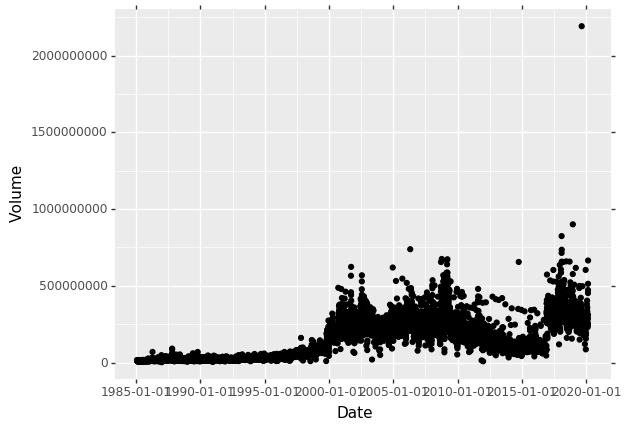

<ggplot: (7551315478)>

In [3]:
p9.ggplot(dj, p9.aes(x = "Date", y = "Volume")) + p9.geom_point()

In [4]:
date_start = "2000-01-01"

starting_amount = 5000

index_dates = dj.loc[dj['Date'] >= date_start, ['Date', 'Open', 'Close']].reset_index(drop = True)


In [5]:
## person who invests and holds

holder = index_dates.copy()

start_shares = starting_amount/holder.loc[0, "Open"]
        
holder['money_value'] = holder['Close']*start_shares

holder['percent_gain'] = 100*holder['money_value']/starting_amount

holder.tail()

,Date,Open,Close,money_value,percent_gain
5065,2020-02-21,29146.529297,28992.410156,12603.368650,252.067373
5066,2020-02-24,28402.929688,27960.800781,12154.914962,243.098299
5067,2020-02-25,28037.650391,27081.359375,11772.610622,235.452212
5068,2020-02-26,27159.460938,26957.589844,11718.806436,234.376129
5069,2020-02-27,26526.000000,25766.640625,11201.085695,224.021714


In [56]:
## METHOD FUNCTIONS
def moving_average(data, params):

    window_days = params[0]
    buy_perc_thresh = params[1]
    sell_perc_thresh = params[2]

    data['last_day'] =  data['Close'].shift(1)
    data['perc_change'] = 100*(data['Close'] - data['last_day'])/data['last_day']
    data['moving_average'] = data['perc_change'].rolling(window_days).mean()

    if buy_perc_thresh <0:
        data['recommendation_buy'] = data['moving_average'] <= buy_perc_thresh
    else:
        data['recommendation_buy'] = data['moving_average'] >= buy_perc_thresh
    
    if sell_perc_thresh <0:
        data['recommendation_sell'] = data['moving_average'] <= sell_perc_thresh
    else:
        data['recommendation_sell'] = data['moving_average'] >= sell_perc_thresh
        
    data['recommendation'] = np.where(data['recommendation_buy'] & data['recommendation_sell'], "hold", \
                                np.where(data['recommendation_buy'], "buy",\
                                    np.where(data['recommendation_sell'], "sell", "hold")))
    
    data['recommendation_lag1'] = data['recommendation'].shift(1)
    data['recommendation_lag2'] = data['recommendation'].shift(2)

    return data

### determine what the waves of buying and selling would have been based on moving average criteria
def determine_buy_sell_waves(data, start_money_type = "cash"):

    money_type = start_money_type

    wave = 0

    wave_data = []

    for row in range(data.shape[0]):

        yesterday_trans_type = data.loc[row, "recommendation_lag1"]

        if (money_type == "cash") & (data.loc[row, "recommendation_lag1"] == "buy"):
            wave = wave + 1
            money_type = "invested"
            true_move = "buy"
            
        elif (money_type == "invested") & (data.loc[row, "recommendation_lag1"] == "sell"):
            true_move = "sell"
            money_type = "cash"
             
        elif data.loc[row, "recommendation_lag2"] == "sell":
            wave = wave + 1
            true_move = "hold"
            
        else:
            true_move = "hold"

        wave_data.append([wave, money_type, true_move])

    wave_df = pd.DataFrame(wave_data, columns = ['wave', 'money_type', "true_move"])

    data = pd.concat([data, wave_df], axis = 1)

    return data

def determine_money_value(data, starting_amount):

    curr_value = starting_amount

    new_data = pd.DataFrame()
    
    print("{} total waves to calculate".format(len(data['wave'].unique())))

    for wave in data['wave'].unique():

        wave_sel = data.loc[data['wave'] == wave].reset_index()

        money_type = wave_sel['money_type'].unique()[0]

        if money_type == "cash":
            wave_sel['money_value'] = curr_value

        elif money_type == "invested":
            start_shares = curr_value/wave_sel.loc[0, "Open"]

            wave_sel['money_value'] = wave_sel['Close']*start_shares

            curr_value = wave_sel['money_value'].iloc[-1]

        new_data = new_data.append(wave_sel)

    return new_data

def strategizer_results(data, method, params, start_money_type = "cash"):

    print('evaluating {}({}, {})'.format(method, "data", params))
    data = eval("{}({}, {})".format(method, "data", params))

    #print('determining waves')
    data = determine_buy_sell_waves(data, start_money_type = start_money_type)
    
    #print('determining money value')
    return determine_money_value(data, 5000)

def determine_final_value(data):
    return data['money_value'].iloc[-1]
    
strategizer_ma = strategizer_results(index_dates, "moving_average", [2, -4, -3])

determine_final_value(strategizer_ma)

evaluating moving_average(data, [2, -4, -3])
17 total waves to calculate


5000

In [55]:
data = moving_average(index_dates, [2, -4, -3])

data = determine_buy_sell_waves(data, start_money_type = "cash")

data

,Date,Open,Close,last_day,perc_change,moving_average,recommendation,recommendation_lag1,recommendation_lag2,recommendation_buy,recommendation_sell,wave,money_type,true_move
0,2000-01-03,11501.849609,11357.509766,NaN,NaN,NaN,hold,NaN,NaN,False,False,0,cash,hold
1,2000-01-04,11349.750000,10997.929688,11357.509766,-3.166012,NaN,hold,hold,NaN,False,False,0,cash,hold
2,2000-01-05,10989.370117,11122.650391,10997.929688,1.134038,-1.015987,hold,hold,hold,False,False,0,cash,hold
3,2000-01-06,11113.370117,11253.259766,11122.650391,1.174265,1.154151,hold,hold,hold,False,False,0,cash,hold
4,2000-01-07,11247.059570,11522.559570,11253.259766,2.393083,1.783674,hold,hold,hold,False,False,0,cash,hold
5,2000-01-10,11532.480469,11572.200195,11522.559570,0.430812,1.411948,hold,hold,hold,False,False,0,cash,hold
6,2000-01-11,11568.469727,11511.080078,11572.200195,-0.528163,-0.048675,hold,hold,hold,False,False,0,cash,hold
7,2000-01-12,11506.730469,11551.099609,11511.080078,0.347661,-0.090251,hold,hold,hold,False,False,0,cash,hold
8,2000-01-13,11558.240234,11582.429688,11551.099609,0.271230,0.309446,hold,hold,hold,False,False,0,cash,hold
9,2000-01-14,11619.349609,11722.980469,11582.429688,1.213483,0.742356,hold,hold,hold,False,False,0,cash,hold


In [57]:
thresh_cutoffs = range(-4, 5)
window_lengths = [2, 4, 6, 8, 10, 12, 14]

all_combos = [[window, buy_thresh, sell_thresh] for window in window_lengths for buy_thresh in thresh_cutoffs for sell_thresh in thresh_cutoffs if sell_thresh != buy_thresh]

all_ma_strategies = []

holder_value = determine_final_value(holder)

for param_combo in all_combos:
    df = strategizer_results(index_dates, "moving_average", param_combo)
    value = determine_final_value(df)
    diff_from_holder = value - holder_value
    
    all_ma_strategies.append([param_combo[0], param_combo[1], param_combo[2], value, diff_from_holder])

all_ma_strategies_df = pd.DataFrame(all_ma_strategies, columns = ['window_days', 'buy_thresh', 'sell_thresh', 'value', 'diff_from_holder'])

all_ma_strategies_df.head()

evaluating moving_average(data, [2, -4, -3])
17 total waves to calculate
evaluating moving_average(data, [2, -4, -2])
61 total waves to calculate
evaluating moving_average(data, [2, -4, -1])
353 total waves to calculate
evaluating moving_average(data, [2, -4, 0])
2753 total waves to calculate
evaluating moving_average(data, [2, -4, 1])
350 total waves to calculate
evaluating moving_average(data, [2, -4, 2])
61 total waves to calculate
evaluating moving_average(data, [2, -4, 3])
16 total waves to calculate
evaluating moving_average(data, [2, -4, 4])
9 total waves to calculate
evaluating moving_average(data, [2, -3, -4])
2 total waves to calculate
evaluating moving_average(data, [2, -3, -2])
45 total waves to calculate
evaluating moving_average(data, [2, -3, -1])
337 total waves to calculate
evaluating moving_average(data, [2, -3, 0])
2761 total waves to calculate
evaluating moving_average(data, [2, -3, 1])
358 total waves to calculate
evaluating moving_average(data, [2, -3, 2])
69 total

evaluating moving_average(data, [4, 1, -1])
194 total waves to calculate
evaluating moving_average(data, [4, 1, 0])
2708 total waves to calculate
evaluating moving_average(data, [4, 1, 2])
2 total waves to calculate
evaluating moving_average(data, [4, 1, 3])
2 total waves to calculate
evaluating moving_average(data, [4, 1, 4])
2 total waves to calculate
evaluating moving_average(data, [4, 2, -4])
4 total waves to calculate
evaluating moving_average(data, [4, 2, -3])
9 total waves to calculate
evaluating moving_average(data, [4, 2, -2])
28 total waves to calculate
evaluating moving_average(data, [4, 2, -1])
166 total waves to calculate
evaluating moving_average(data, [4, 2, 0])
2823 total waves to calculate
evaluating moving_average(data, [4, 2, 1])
116 total waves to calculate
evaluating moving_average(data, [4, 2, 3])
2 total waves to calculate
evaluating moving_average(data, [4, 2, 4])
2 total waves to calculate
evaluating moving_average(data, [4, 3, -4])
4 total waves to calculate
e

2 total waves to calculate
evaluating moving_average(data, [8, -3, 4])
2 total waves to calculate
evaluating moving_average(data, [8, -2, -4])
2 total waves to calculate
evaluating moving_average(data, [8, -2, -3])
2 total waves to calculate
evaluating moving_average(data, [8, -2, -1])
52 total waves to calculate
evaluating moving_average(data, [8, -2, 0])
2962 total waves to calculate
evaluating moving_average(data, [8, -2, 1])
39 total waves to calculate
evaluating moving_average(data, [8, -2, 2])
4 total waves to calculate
evaluating moving_average(data, [8, -2, 3])
2 total waves to calculate
evaluating moving_average(data, [8, -2, 4])
2 total waves to calculate
evaluating moving_average(data, [8, -1, -4])
2 total waves to calculate
evaluating moving_average(data, [8, -1, -3])
2 total waves to calculate
evaluating moving_average(data, [8, -1, -2])
2 total waves to calculate
evaluating moving_average(data, [8, -1, 0])
2975 total waves to calculate
evaluating moving_average(data, [8, 

1 total waves to calculate
evaluating moving_average(data, [10, 3, -2])
4 total waves to calculate
evaluating moving_average(data, [10, 3, -1])
45 total waves to calculate
evaluating moving_average(data, [10, 3, 0])
2968 total waves to calculate
evaluating moving_average(data, [10, 3, 1])
25 total waves to calculate
evaluating moving_average(data, [10, 3, 2])
1 total waves to calculate
evaluating moving_average(data, [10, 3, 4])
1 total waves to calculate
evaluating moving_average(data, [10, 4, -4])
1 total waves to calculate
evaluating moving_average(data, [10, 4, -3])
1 total waves to calculate
evaluating moving_average(data, [10, 4, -2])
4 total waves to calculate
evaluating moving_average(data, [10, 4, -1])
45 total waves to calculate
evaluating moving_average(data, [10, 4, 0])
2968 total waves to calculate
evaluating moving_average(data, [10, 4, 1])
25 total waves to calculate
evaluating moving_average(data, [10, 4, 2])
1 total waves to calculate
evaluating moving_average(data, [1

3056 total waves to calculate
evaluating moving_average(data, [14, -1, 1])
9 total waves to calculate
evaluating moving_average(data, [14, -1, 2])
2 total waves to calculate
evaluating moving_average(data, [14, -1, 3])
2 total waves to calculate
evaluating moving_average(data, [14, -1, 4])
2 total waves to calculate
evaluating moving_average(data, [14, 0, -4])
2 total waves to calculate
evaluating moving_average(data, [14, 0, -3])
2 total waves to calculate
evaluating moving_average(data, [14, 0, -2])
2 total waves to calculate
evaluating moving_average(data, [14, 0, -1])
38 total waves to calculate
evaluating moving_average(data, [14, 0, 1])
2 total waves to calculate
evaluating moving_average(data, [14, 0, 2])
2 total waves to calculate
evaluating moving_average(data, [14, 0, 3])
2 total waves to calculate
evaluating moving_average(data, [14, 0, 4])
2 total waves to calculate
evaluating moving_average(data, [14, 1, -4])
2 total waves to calculate
evaluating moving_average(data, [14, 

,window_days,buy_thresh,sell_thresh,value,diff_from_holder
0,2,-4,-3,5000.000000,-6201.085695
1,2,-4,-2,5000.000000,-6201.085695
2,2,-4,-1,5000.000000,-6201.085695
3,2,-4,0,6285.760329,-4915.325366
4,2,-4,1,6312.620481,-4888.465214


In [42]:
df = strategizer_results(index_dates, "moving_average", [3, 2, -1])

df

evaluating moving_average(data, [3, 2, -1])


,index,Date,Open,Close,last_day,perc_change,moving_average,recommendation,recommendation_lag1,recommendation_lag2,recommendation_buy,recommendation_sell,wave,money_type,true_move,money_value
0,0,2000-01-03,11501.849609,11357.509766,NaN,NaN,NaN,hold,NaN,NaN,False,False,0,cash,hold,5000
1,1,2000-01-04,11349.750000,10997.929688,11357.509766,-3.166012,NaN,hold,hold,NaN,False,False,0,cash,hold,5000
2,2,2000-01-05,10989.370117,11122.650391,10997.929688,1.134038,NaN,hold,hold,hold,False,False,0,cash,hold,5000
3,3,2000-01-06,11113.370117,11253.259766,11122.650391,1.174265,-0.285903,hold,hold,hold,True,True,0,cash,hold,5000
4,4,2000-01-07,11247.059570,11522.559570,11253.259766,2.393083,1.567128,hold,hold,hold,True,True,0,cash,hold,5000
5,5,2000-01-10,11532.480469,11572.200195,11522.559570,0.430812,1.332720,hold,hold,hold,True,True,0,cash,hold,5000
6,6,2000-01-11,11568.469727,11511.080078,11572.200195,-0.528163,0.765244,hold,hold,hold,True,True,0,cash,hold,5000
7,7,2000-01-12,11506.730469,11551.099609,11511.080078,0.347661,0.083437,hold,hold,hold,True,True,0,cash,hold,5000
8,8,2000-01-13,11558.240234,11582.429688,11551.099609,0.271230,0.030243,hold,hold,hold,True,True,0,cash,hold,5000
9,9,2000-01-14,11619.349609,11722.980469,11582.429688,1.213483,0.610791,hold,hold,hold,True,True,0,cash,hold,5000


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


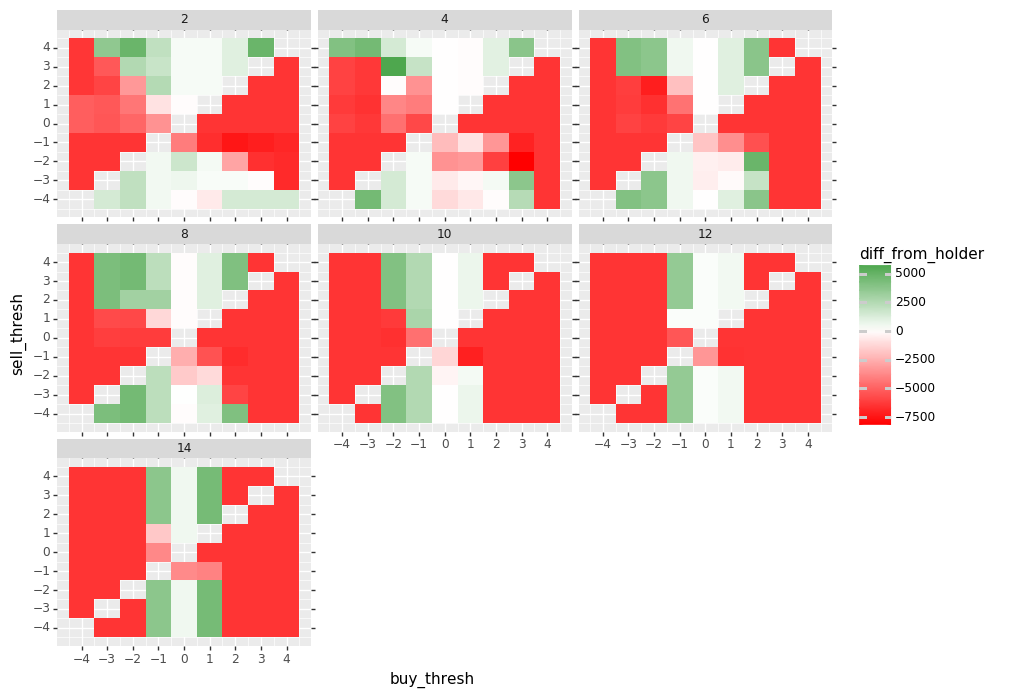

<ggplot: (7554385949)>

In [59]:
p9.options.figure_size = (10, 8)

(p9.ggplot(all_ma_strategies_df, p9.aes(x = "buy_thresh", y = "sell_thresh", fill = "diff_from_holder")) + 
p9.geom_tile() + 
p9.scale_fill_gradient2(low = "red", mid = "white", high = "green", midpoint = 0) +
p9.scale_x_continuous(breaks = thresh_cutoffs) +
p9.scale_y_continuous(breaks = thresh_cutoffs) +
p9.facet_wrap("~window_days"))

evaluating moving_average(data, [2, -2, 3])
24 total waves to calculate


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


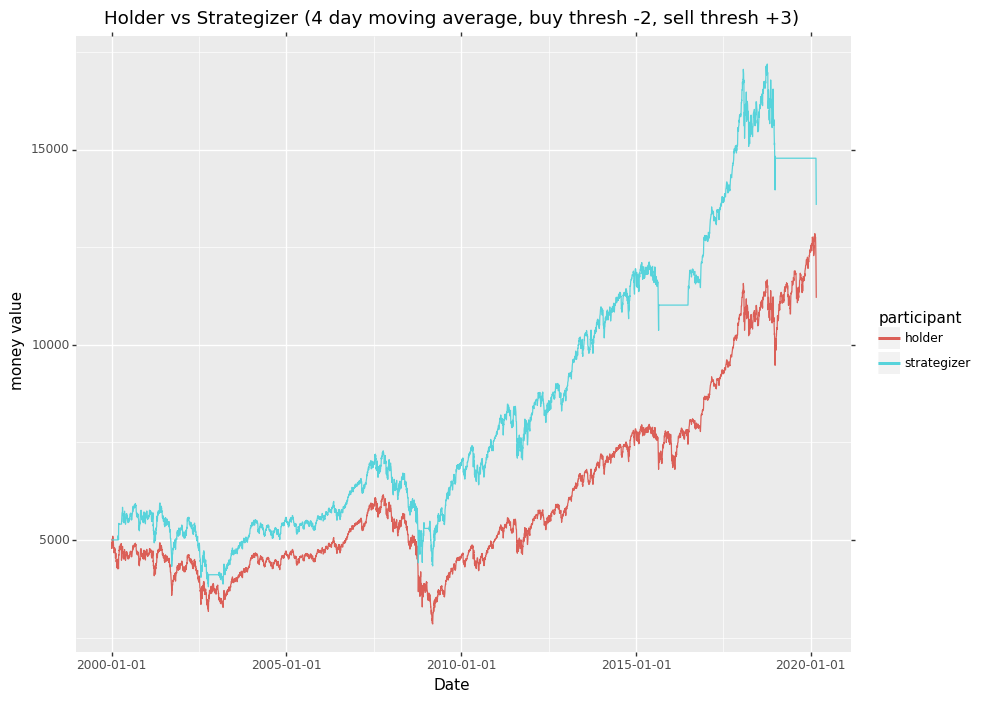

<ggplot: (7555248367)>

In [62]:
strategizer_ma = strategizer_results(index_dates, "moving_average", [2, -2, 3])

holder['participant'] = "holder"
strategizer_ma['participant'] = "strategizer"

plot_data = pd.concat([holder, strategizer_ma])

(p9.ggplot(plot_data, p9.aes(x = "Date", y = "money_value", color = "participant")) +
p9.labs(y = "money value", title = "Holder vs Strategizer (4 day moving average, buy thresh -2, sell thresh +3)") +
p9.geom_line())


/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/Users/jmaddalena/anaconda3/lib/python3.6/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


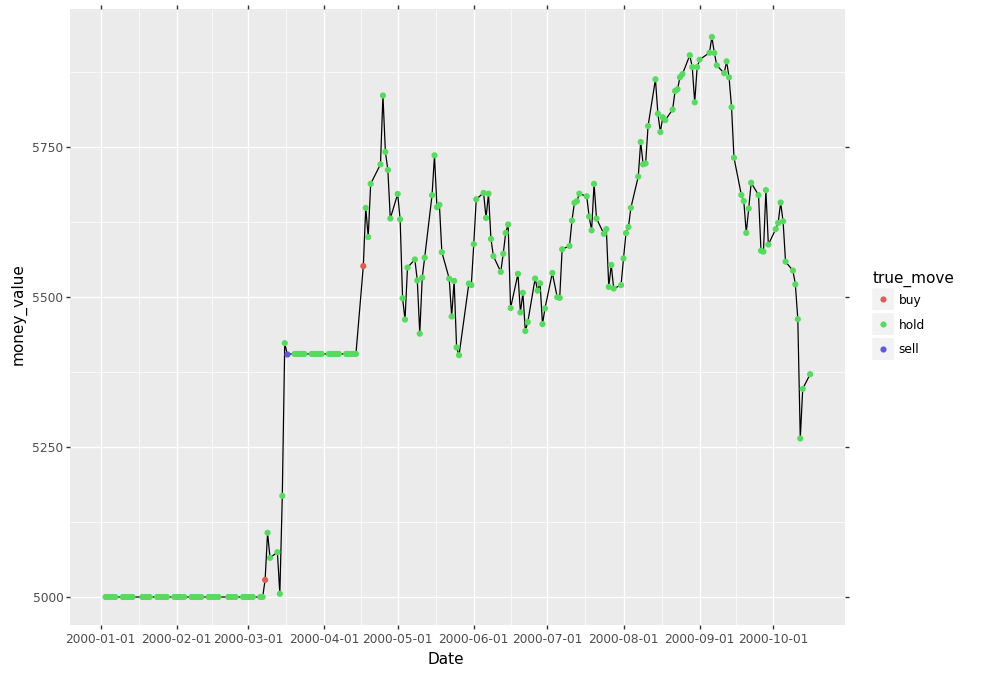

<ggplot: (7555449899)>

In [64]:
(p9.ggplot(strategizer_ma[:200], p9.aes(x = "Date", y = "money_value")) +
p9.geom_line() +
p9.geom_point(p9.aes(color = "true_move")))

In [ ]:
### something is broken 
### need to fix why selling money value is same as previous day - it's already being handled as cash
### does it need to be part of the previous wave, so wave would be buy - hold - ... - hold - sell?